In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 140 # 200 e.g. is really fine, but slower
from scipy import fft, signal
import scipy
from scipy.io.wavfile import read


Text(0, 0.5, 'Magnitude')

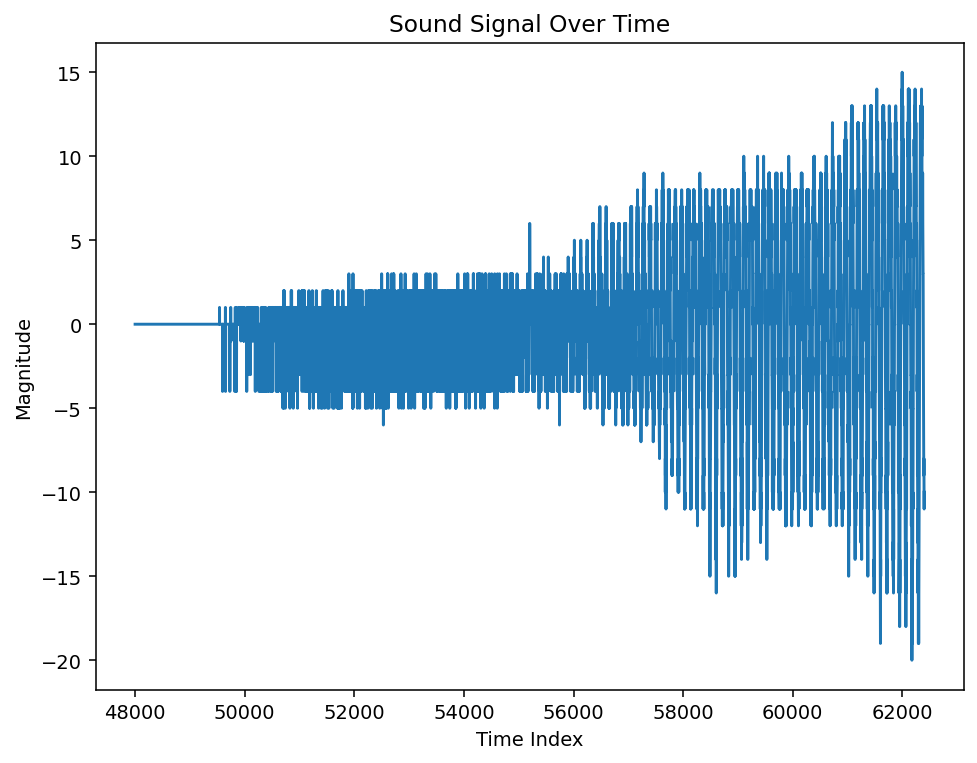

In [20]:
# Read the input WAV files
# Fs is the sampling frequency of the file
Fs, song = read("audios/visitinghours.wav")
song=song[:,0]
time_to_plot = np.arange(Fs * 1, Fs * 1.3, dtype=int)
plt.plot(time_to_plot, song[time_to_plot])
plt.title("Sound Signal Over Time")
plt.xlabel("Time Index")
plt.ylabel("Magnitude")

Text(0.5, 0, 'Frequency (Hz)')

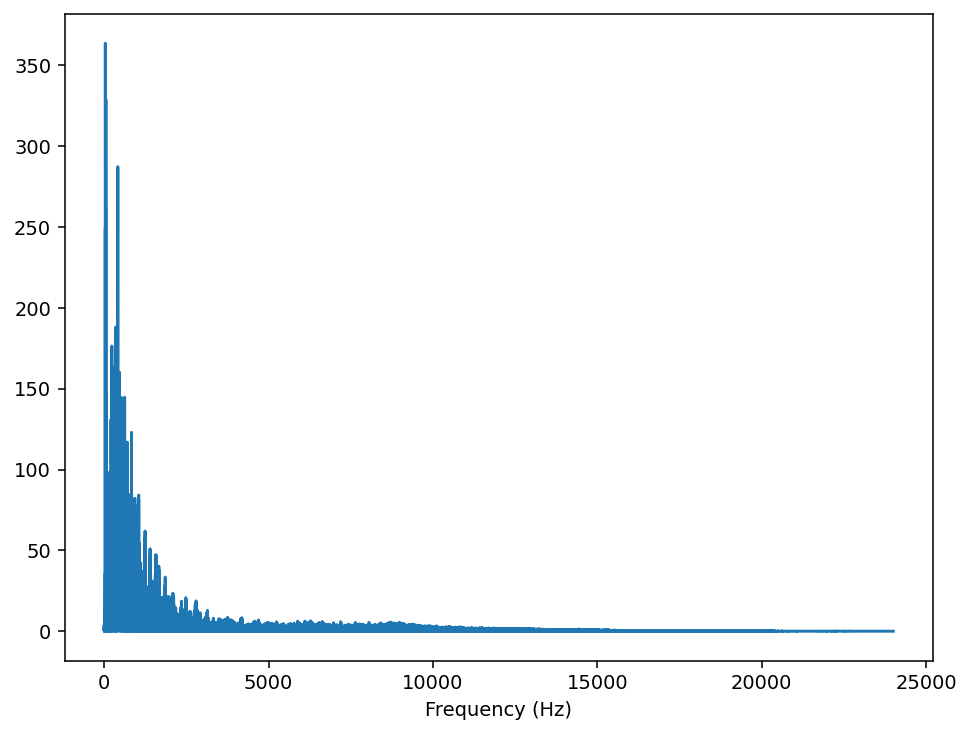

In [21]:
N = len(song)
fft = scipy.fft.fft(song)
transform_y = 2.0 / N * np.abs(fft[0:N//2])
transform_x = scipy.fft.fftfreq(N, 1 / Fs)[:N//2]
plt.plot(transform_x, transform_y)
plt.xlabel("Frequency (Hz)")

(0.0, 2000.0)

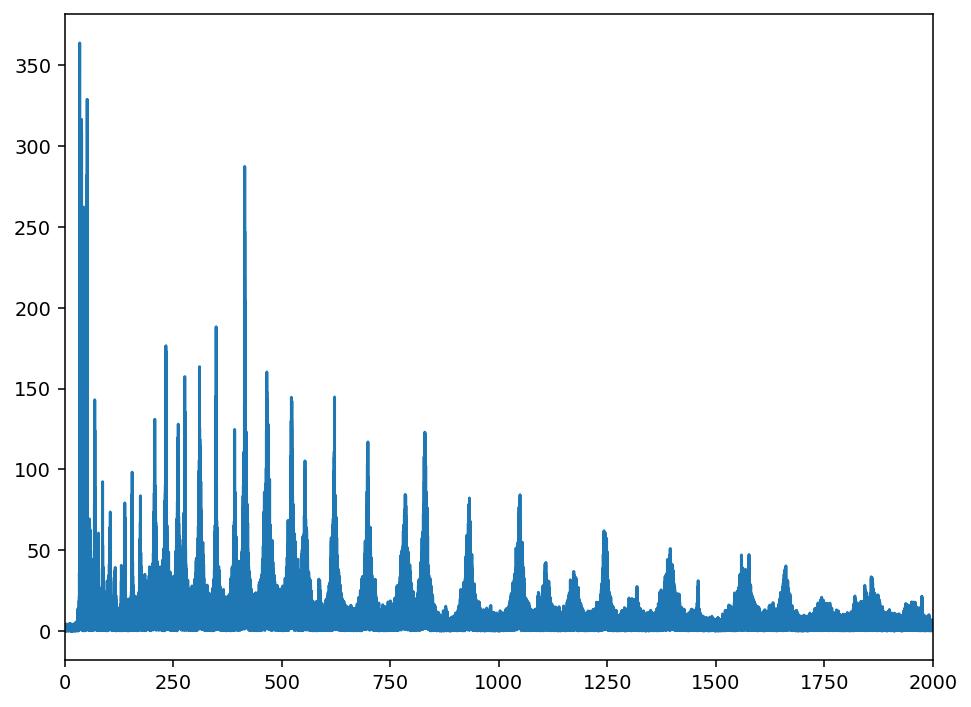

In [22]:
plt.plot(transform_x, transform_y)
plt.xlim(0, 2000)

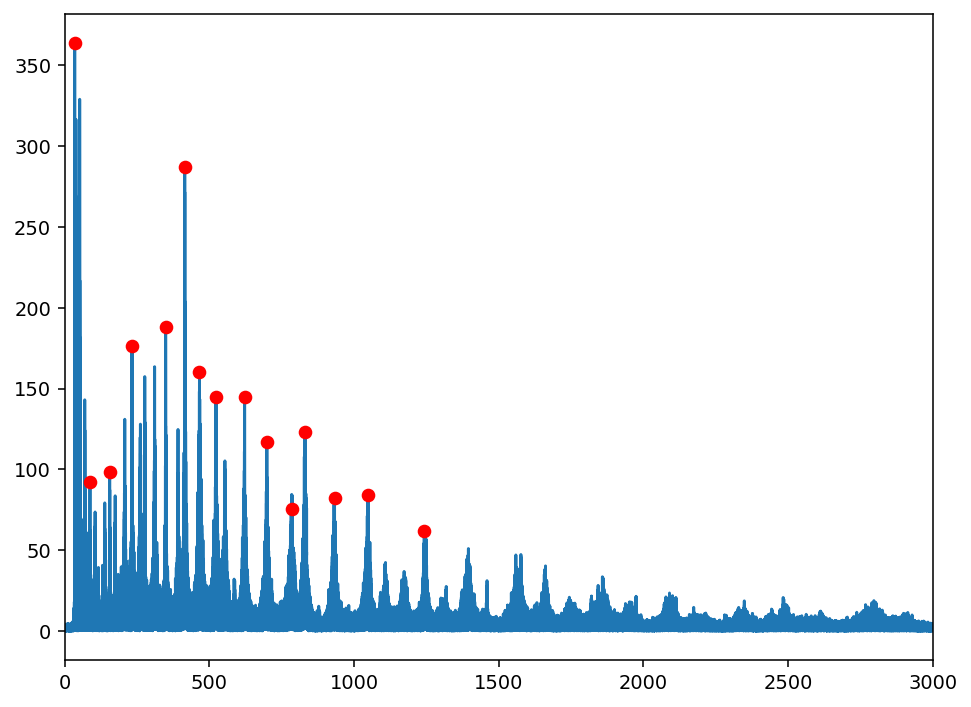

In [23]:
all_peaks, props = signal.find_peaks(transform_y)
peaks, props = signal.find_peaks(transform_y, prominence=0, distance=10000)
n_peaks = 15
# Get the n_peaks largest peaks from the prominences
# This is an argpartition
# Useful explanation: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
largest_peaks_indices = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
largest_peaks = peaks[largest_peaks_indices]
plt.plot(transform_x, transform_y, label="Spectrum")
plt.scatter(transform_x[largest_peaks], transform_y[largest_peaks], color="r", zorder=10, label="Constrained Peaks")
plt.xlim(0, 3000)
plt.show()

In [29]:
def create_constellation(audio, Fs):
    # Parameters
    window_length_seconds = 0.5
    window_length_samples = int(window_length_seconds * Fs)
    window_length_samples += window_length_samples % 2
    num_peaks = 15
    # Pad the song to divide evenly into windows
    amount_to_pad = window_length_samples - audio.size % window_length_samples
    song_input = np.pad(audio, (0, amount_to_pad))
    # Perform a short time fourier transform
    frequencies, times, stft = signal.stft(
        song_input, Fs, nperseg=window_length_samples, nfft=window_length_samples, return_onesided=True
    )
    constellation_map = []
    for time_idx, window in enumerate(stft.T):
        # Spectrum is by default complex. 
        # We want real values only
        spectrum = abs(window)
        # Find peaks - these correspond to interesting features
        # Note the distance - want an even spread across the spectrum
        peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)
        # Only want the most prominent peaks
        # With a maximum of 15 per time slice
        n_peaks = min(num_peaks, len(peaks))
        # Get the n_peaks largest peaks from the prominences
        # This is an argpartition
        # Useful explanation: https://kanoki.org/2020/01/14/find-k-smallest-and-largest-values-and-its-indices-in-a-numpy-array/
        largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
        for peak in peaks[largest_peaks]:
            frequency = frequencies[peak]
            constellation_map.append([time_idx, frequency])
    return constellation_map

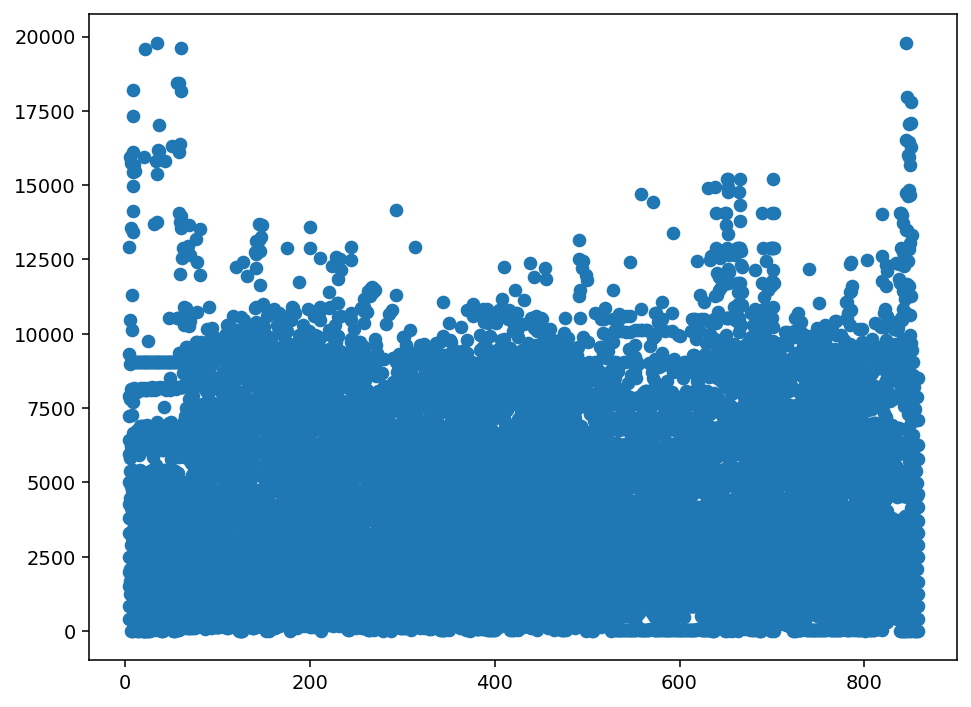

In [30]:
const_map = create_constellation(song, Fs)
plt.scatter(*zip(*const_map))
